# Pulse sequence evaluation

Using arbitrary units. Energy is normalized to the standard deviation in chemical shift strengths. Reduced Planck's constant $\hbar \equiv 1$.

In [2]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import pandas as pd
import multiprocessing as mp
import importlib

In [3]:
sys.path.append('..')

In [4]:
import pulse_sequences as ps

In [41]:
# importlib.reload(ps)

<module 'pulse_sequences' from '../pulse_sequences.py'>

## Define system

In [5]:
dipolar_strength = 1e2
pulse_width = 1e-5  # time is relative to chemical shift strength
delay = 1e-4
rot_error = 1e-2
N = 3  # number of spins
ensemble_size = 25

In [6]:
X, Y, Z = ps.get_collective_spin(N)

In [7]:
Hsys_ensemble = [ps.get_Hsys(N, dipolar_strength=dipolar_strength) for _ in range(ensemble_size)]
pulses_ensemble = []
for H in Hsys_ensemble:
    rot = np.random.normal(scale=rot_error)
    pulses_ensemble.append(ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=rot))

In [8]:
Utarget = qt.identity(Hsys_ensemble[0].dims[0])

## Define shorter pulse sequences

These are from 3/6-3/8 runs.

In [9]:
az12 = [1, 3, 3, 1, 3, 3, 1, 4, 4, 1, 4, 4]

az24 = [
    3, 3, 1, 3, 3, 1, 3, 3, 2, 3, 3, 2,
    4, 4, 2, 4, 4, 2, 4, 4, 1, 4, 4, 1
]

az36 = [
    2, 2, 4, 2, 2, 4, 1, 1, 4, 1, 1, 4,
    4, 2, 2, 4, 2, 2, 4, 2, 3, 2, 2, 3,
    2, 1, 1, 4, 1, 1, 4, 4, 1, 4, 4, 1
]

az48 = [
    3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1,
    3, 3, 1, 3, 3, 1, 3, 3, 2, 3, 3, 2,
    1, 4, 1, 1, 4, 1, 4, 1, 3, 3, 3, 1,
    3, 4, 1, 1, 1, 4, 4, 1, 4, 4, 1, 4
]

az96 = [
    2, 4, 2, 2, 4, 2, 2, 3, 3, 1, 3, 3,
    1, 3, 2, 3, 3, 2, 4, 4, 2, 4, 4, 2,
    1, 1, 3, 1, 1, 3, 4, 1, 1, 4, 1, 1,
    4, 2, 2, 4, 2, 2, 2, 4, 1, 1, 1, 4,
    4, 4, 1, 4, 4, 1, 1, 1, 4, 1, 4, 1,
    1, 1, 4, 1, 1, 4, 1, 3, 1, 1, 3, 1,
    2, 2, 4, 4, 2, 4, 4, 1, 4, 1, 1, 4,
    3, 1, 1, 3, 1, 1, 3, 4, 2, 2, 4, 2
]

## Define and evaluate pulse sequences



In [50]:
f = ps.get_mean_fidelity(ps.cory48, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9999986025564618, 5.854665730156923)

In [51]:
f = ps.get_mean_fidelity(ps.yxx24 * 2, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9999992067970132, 6.100615659104439)

In [52]:
f = ps.get_mean_fidelity(ps.yxx48, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.99999806394473, 5.713082248727281)

In [53]:
f = ps.get_mean_fidelity(ps.az3, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9987572175400632, 2.905604884807481)

In [54]:
f = ps.get_mean_fidelity(ps.az48, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9999506235042941, 4.306479735578446)

In [55]:
f = ps.get_mean_fidelity(ps.az48_1, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.999908668716844, 4.039380440702656)

In [56]:
f = ps.get_mean_fidelity(ps.az48_2, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9998735179805636, 3.897971208990623)

In [57]:
f = ps.get_mean_fidelity(ps.az48_3, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9999922433325031, 5.110324824950492)

## Evaluate robustness

Looking at several different sources of errors:

- Non-negligible higher-order terms in Magnus expansion
- Rotation errors
- Phase transients
- Offset errors

### Rotation errors

In [26]:
rot_errors = np.linspace(-1, 1, 15)
rot_errors = .05 * rot_errors**2 * np.sign(rot_errors) # non-linear sampling

In [27]:
def f(pulse_sequence, rot_error):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=rot_error) for H in Hsys_ensemble]
    U_ensemble = [ps.get_propagator(pulse_sequence, p) for p in pe]
    U_ensemble_full = []
    for U in U_ensemble:
        U_full = qt.identity(U.dims[0])
        for _ in range(int(288/len(pulse_sequence))):
            U_full = U * U_full
        U_ensemble_full.append(U_full)
    fidelities = np.array([qt.metrics.average_gate_fidelity(U, Utarget)
                           for U in U_ensemble_full])
    return np.mean(fidelities), np.std(fidelities)

In [28]:
def get_rot_data(pulse_sequence, rot_errors, num_workers=4):
    with mp.Pool(num_workers) as p:
        output = p.starmap(f, [(pulse_sequence, r) for r in rot_errors])
    
    fidelity, fidelity_std = zip(*output)
    fidelity = np.array(fidelity)
    fidelity_std = np.array(fidelity_std)
    
    return fidelity, fidelity_std

In [29]:
cory48_output = get_rot_data(ps.cory48, rot_errors)

In [31]:
yxx48_output = get_rot_data(ps.yxx48, rot_errors)

In [32]:
az48_3_output = get_rot_data(ps.az48_3, rot_errors)

In [66]:
az12_output = get_rot_data(az12, rot_errors)

In [67]:
az24_output = get_rot_data(az24, rot_errors)

In [68]:
az36_output = get_rot_data(az36, rot_errors)

In [69]:
az96_output = get_rot_data(az96, rot_errors)

In [64]:
# default figure size is [6.0, 4.0]
plt.rcParams['figure.figsize'] = [5, 3.33]
# default dpi is 72
plt.rcParams['figure.dpi'] = 144

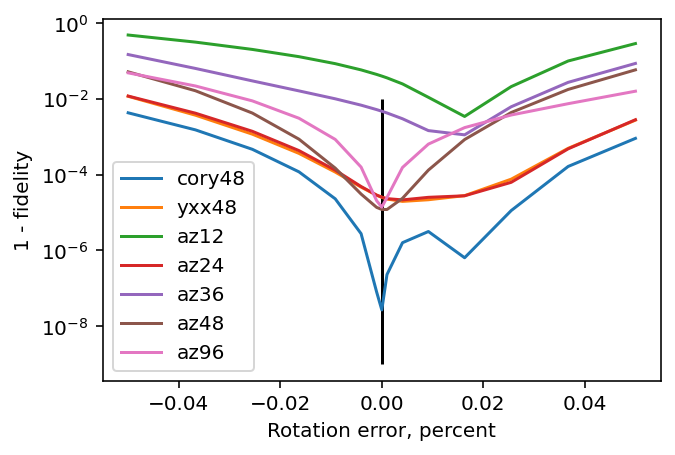

In [73]:
plt.plot(rot_errors, 1-cory48_output[0], label='cory48')
plt.plot(rot_errors, 1-yxx48_output[0], label='yxx48')

plt.plot(rot_errors, 1-az12_output[0], label='az12')
plt.plot(rot_errors, 1-az24_output[0], label='az24')
plt.plot(rot_errors, 1-az36_output[0], label='az36')
plt.plot(rot_errors, 1-az48_3_output[0], label='az48')
plt.plot(rot_errors, 1-az96_output[0], label='az96')

plt.vlines(0, 10**-9, 10**-2, 'k')
plt.xlabel('Rotation error, percent')
plt.ylabel('1 - fidelity')
plt.yscale('log')
plt.legend()
plt.savefig('rot_errors.pdf', bbox_inches='tight')

In [43]:
# plt.errorbar(rot_errors, 1-cory48_output[0], yerr=cory48_output[1], label='cory48')
# plt.errorbar(rot_errors, 1-yxx48_output[0], yerr=yxx48_output[1], label='yxx48')
# # plt.errorbar(rot_errors, 1-yxx24_output[0], yerr=yxx24_output[1], label='yxx24')
# # plt.errorbar(rot_errors, 1-az3_output[0], yerr=az3_output[1], label='az3')
# # plt.errorbar(rot_errors, 1-az12_output[0], yerr=az12_output[1], label='az12')
# plt.errorbar(rot_errors, 1-az48_output[0], yerr=az48_output[1], label='az48')
# plt.errorbar(rot_errors, 1-az48_1_output[0], yerr=az48_1_output[1], label='az48_1')
# plt.xlabel('Rotation error, percent')
# plt.ylabel('1 - fidelity')
# plt.yscale('log')
# plt.legend()

### Phase transients

In [41]:
phase_transients = 1e-2 * np.linspace(0, 1, 15)**2

In [42]:
def g(pulse_sequence, pt):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, phase_transient=pt) for H in Hsys_ensemble]
    U_ensemble = [ps.get_propagator(pulse_sequence, p) for p in pe]
    U_ensemble_full = []
    for U in U_ensemble:
        U_full = qt.identity(U.dims[0])
        for _ in range(int(288/len(pulse_sequence))):
            U_full = U * U_full
        U_ensemble_full.append(U_full)
    fidelities = np.array([qt.metrics.average_gate_fidelity(U, Utarget)
                           for U in U_ensemble_full])
    return np.mean(fidelities), np.std(fidelities)

In [43]:
def get_pt_data(pulse_sequence, phase_transients, num_workers=4):
    with mp.Pool(num_workers) as p:
        output = p.starmap(g, [(pulse_sequence, r) for r in phase_transients])
    
    fidelity, fidelity_std = zip(*output)
    fidelity = np.array(fidelity)
    fidelity_std = np.array(fidelity_std)
    
    return fidelity, fidelity_std

In [44]:
cory48_pt_output = get_pt_data(ps.cory48, phase_transients)

In [45]:
yxx48_pt_output = get_pt_data(ps.yxx48, phase_transients)

In [46]:
az48_3_pt_output = get_pt_data(ps.az48_3, phase_transients)

In [57]:
az12_pt_output = get_pt_data(az12, phase_transients)

In [58]:
az24_pt_output = get_pt_data(az24, phase_transients)

In [59]:
az36_pt_output = get_pt_data(az36, phase_transients)

In [60]:
az96_pt_output = get_pt_data(az96, phase_transients)

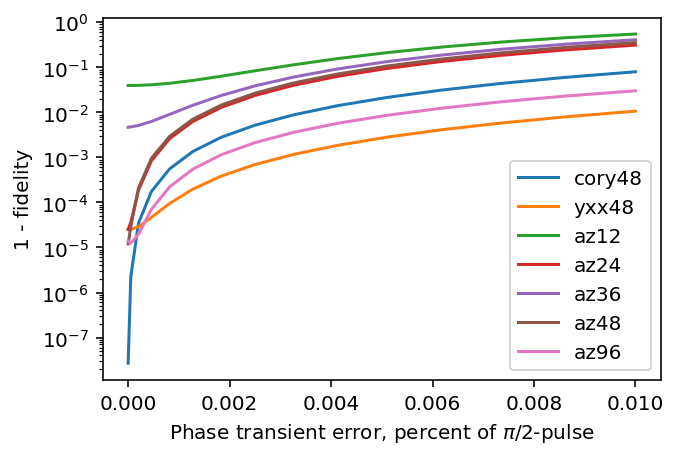

In [72]:
plt.plot(phase_transients, 1-cory48_pt_output[0], label='cory48')
plt.plot(phase_transients, 1-yxx48_pt_output[0], label='yxx48')

plt.plot(phase_transients, 1-az12_pt_output[0], label='az12')
plt.plot(phase_transients, 1-az24_pt_output[0], label='az24')
plt.plot(phase_transients, 1-az36_pt_output[0], label='az36')
plt.plot(phase_transients, 1-az48_3_pt_output[0], label='az48')
plt.plot(phase_transients, 1-az96_pt_output[0], label='az96')

plt.yscale('log')
plt.xlabel(r'Phase transient error, percent of $\pi/2$-pulse')
plt.ylabel('1 - fidelity')
plt.legend()
plt.savefig('phase_transient_error.png')
plt.savefig('phase_transients.pdf', bbox_inches='tight')

In [82]:
# plt.errorbar(phase_transients, 1-cory48_pt_output[0], yerr=cory48_pt_output[1], label='cory48')
# plt.errorbar(phase_transients, 1-yxx48_pt_output[0], yerr=yxx48_pt_output[1], label='yxx48')
# # plt.errorbar(phase_transients, 1-yxx24_pt_output[0], yerr=yxx24_pt_output[1], label='yxx24')
# # plt.errorbar(phase_transients, 1-az3_pt_output[0], yerr=az3_pt_output[1], label='az3')
# plt.errorbar(phase_transients, 1-az48_pt_output[0], yerr=az48_pt_output[1], label='az48')
# plt.yscale('log')
# plt.xlabel(r'Phase transient error, percent of $\pi/2$-pulse')
# plt.ylabel('1 - fidelity')
# plt.legend()

## Evaluate AZ performance by pulse sequence length

In [10]:
U12 = [ps.get_propagator(az12, p) for p in pulses_ensemble]
U24 = [ps.get_propagator(az24, p) for p in pulses_ensemble]
U36 = [ps.get_propagator(az36, p) for p in pulses_ensemble]
U48 = [ps.get_propagator(az48, p) for p in pulses_ensemble]
U96 = [ps.get_propagator(az96, p) for p in pulses_ensemble]

In [24]:
len(ps.cory48)

72

In [25]:
np.lcm.reduce([12, 24, 36, 48, 72, 96])

288

In [12]:
U12_full = []
for U in U12:
    U_full = qt.identity(U.dims[0])
    for _ in range(int(288/12)):
        U_full = U * U_full
    U12_full.append(U_full)

In [13]:
U24_full = []
for U in U24:
    U_full = qt.identity(U.dims[0])
    for _ in range(int(288/24)):
        U_full = U * U_full
    U24_full.append(U_full)

In [14]:
U36_full = []
for U in U36:
    U_full = qt.identity(U.dims[0])
    for _ in range(int(288/36)):
        U_full = U * U_full
    U36_full.append(U_full)

In [15]:
U48_full = []
for U in U48:
    U_full = qt.identity(U.dims[0])
    for _ in range(int(288/48)):
        U_full = U * U_full
    U48_full.append(U_full)

In [16]:
U96_full = []
for U in U96:
    U_full = qt.identity(U.dims[0])
    for _ in range(int(288/96)):
        U_full = U * U_full
    U96_full.append(U_full)

In [17]:
fid12 = np.array([qt.metrics.average_gate_fidelity(U, qt.identity([2]*3)) for U in U12_full])
fid24 = np.array([qt.metrics.average_gate_fidelity(U, qt.identity([2]*3)) for U in U24_full])
fid36 = np.array([qt.metrics.average_gate_fidelity(U, qt.identity([2]*3)) for U in U36_full])
fid48 = np.array([qt.metrics.average_gate_fidelity(U, qt.identity([2]*3)) for U in U48_full])
fid96 = np.array([qt.metrics.average_gate_fidelity(U, qt.identity([2]*3)) for U in U96_full])

In [18]:
fid_means = np.array([fid12.mean(), fid24.mean(), fid36.mean(), fid48.mean(), fid96.mean()])

In [19]:
fid_stds = np.array([fid12.std(), fid24.std(), fid36.std(), fid48.std(), fid96.std()])

In [20]:
fid_stds

array([0.070728  , 0.00023681, 0.00869011, 0.00071491, 0.00106102])

Fidelities are corrected for differences in pulse sequence length.

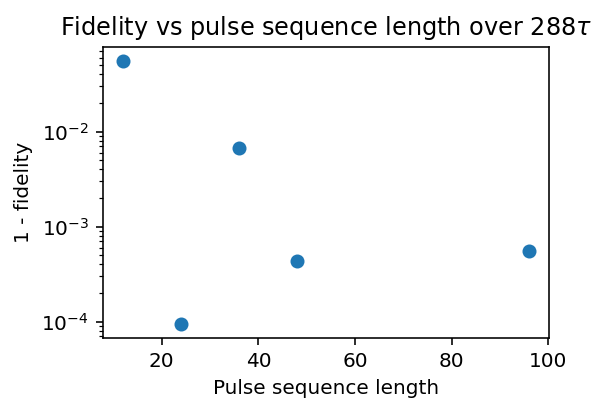

In [23]:
plt.scatter([12, 24, 36, 48, 96], 1 - fid_means)
plt.yscale('log')
plt.xlabel('Pulse sequence length')
plt.ylabel('1 - fidelity')
plt.title(r'Fidelity vs pulse sequence length over 288$\tau$')
plt.savefig('pulse-sequence-length.pdf', bbox_inches='tight')